<a href="https://colab.research.google.com/github/Dominic-byte/Team-13-Regression-Predict/blob/master/Copy_of_Sendy_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 13 Sendy Logistics Challenge

## Contents (finish sections 4, 5, 8, 9)

1. Introduction
2. Imports
3. Definitions
4. Data cleaning and preprocessing
5. Exploratory data analysis
6. Feature engineering and selection
7. Model building
8. Results interpretation
9. Conclusion

## 1. Introduction

**Problem Landscape**

*About Sendy:* Sendy is a platform established to enable businesses to transport goods efficently across East Africa. Sendy focuses on on building practical solutions for Africa's transportation needs, from developing apps and web solutions, to providing dedicated support for goods on the move.

*Problem* Sendy would like to be able to predict the estimated time of delivery of orders from the point of driver pickup to the point of arrival at final destination.

*Value* This will help Sendy improve customer experience by enhancing customer communication and improving service reliability. In addition, the solution will enable the realisation of cost savings through improved resource management.

*Problem Statement*: **Build** a model to predict the estimated time of delivery of orders from the **`point of driver pickup`** to the **`point of arrival at final destination`**.

## 2. Imports

!pip install bayesian-optimization
!pip install geopy
!pip install scikit-optimize

Packages

In [0]:
%%capture
# Standard Imports
import numpy as np
import pandas as pd
import datetime

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
import geopy.distance

# Modelling
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
import lightgbm as lgb

#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV

# Storing Model
import pickle

# Notebook Settings
%matplotlib inline
pd.options.display.max_columns = 60
sns.set_style("whitegrid")

Data

In [0]:
# URL to training and testing data
trurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Train.csv'
turl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Test.csv'
rurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/Riders.csv'
vurl = 'https://raw.githubusercontent.com/Dominic-byte/Team-13-Regression-Predict/master/VariableDefinitions.csv'

# Loading datasets
train_df = pd.read_csv(trurl, index_col=0)
test_df = pd.read_csv(turl, index_col=0)
riders_df = pd.read_csv(rurl)
variables = pd.read_csv(vurl, index_col=0)

## 3. Definitions

In [0]:
pd.options.display.max_colwidth = 0
variables

,Unique number identifying the order
Order No,
User Id,Unique number identifying the customer on a platform
Vehicle Type,"For this competition limited to bikes, however in practice Sendy service extends to trucks and vans"
Platform Type,"Platform used to place the order, there are 4 types"
Personal or Business,Customer type
Placement - Day of Month,Placement - Day of Month i.e 1-31
Placement - Weekday (Mo = 1),Placement - Weekday (Monday = 1)
Placement - Time,Placement - Time - Time of day the order was placed
Confirmation - Day of Month,Confirmation - Day of Month i.e 1-31
Confirmation - Weekday (Mo = 1),Confirmation - Weekday (Monday = 1)


In [0]:
pd.options.display.max_colwidth = 50

In [0]:
def col_rename(df):
  """Function that renames columns and drops columns that 
  were not used in the test set
  Parameters
  ----------
  df: DataFrame
          input df to rename columns for
  Returns
  -------
  new_df: DataFrame
          output df with renamed and dropped columns
          as well as a printout of dropped columns
  """
  static_dict = {"Order No":"Order No","User Id":"User Id","Vehicle Type":"Vehicle Type","Platform Type":"Platform",
        "Personal or Business":"Pers Business","Placement - Day of Month":"Place DoM",
        "Placement - Weekday (Mo = 1)":"Place Weekday","Placement - Time":"Place Time",
        "Confirmation - Day of Month":"Confirm DoM","Confirmation - Weekday (Mo = 1)":"Confirm Weekday",
        "Confirmation - Time":"Confirm Time","Arrival at Pickup - Day of Month":"Arr Pickup DoM",
        "Arrival at Pickup - Weekday (Mo = 1)":"Arr Pickup Weekday","Arrival at Pickup - Time":"Arr Pickup Time",
        "Pickup - Day of Month":"Pickup DoM","Pickup - Weekday (Mo = 1)":"Pickup Weekday","Pickup - Time":"Pickup Time",
        "Distance (KM)":"Distance KM","Temperature":"Temperature","Precipitation in millimeters":"Precipitation mm",
        "Pickup Lat":"Pickup Lat","Pickup Long":"Pickup Long","Destination Lat":"Destination Lat","Time from Pickup to Arrival":"Time from Pickup to Arrival",
        "Destination Long":"Destination Long","Rider Id":"Rider Id"}
  new_df = df.copy()
  new_cols = {}
  droplist = []
  for col in new_df.columns:
    if col in static_dict.keys():
      new_cols[col] = static_dict[col].replace(" ","_")
    else:
      droplist.append(col)
  new_df.rename(columns = new_cols, inplace=True)
  for col in droplist:
    if col in new_df.index:
      return new_df.drop(columns=droplist, inplace=True)
  return new_df

In [0]:
atrain_df  = col_rename(train_df)
atest_df =  col_rename(test_df)
ariders_df = col_rename(riders_df)

In [0]:
for col in atrain_df.columns:
    if col not in atest_df.columns and col != 'Time_from_Pickup_to_Arrival':
        print(col)
        atrain_df.drop(columns=col, inplace = True)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time


In [0]:
# Storing variable names and test index
train_columns = atrain_df.columns
test_columns = atest_df.columns
riders_columns = ariders_df.columns
test_index = atest_df.index
target = train_columns[-1]

# Inspect data
print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head(3)
print(target)

(21201, 28) (7068, 24) (960, 5)
Time_from_Pickup_to_Arrival


## 4. Data cleaning and preprocessing (BBP)

In [0]:
pd.merge(atrain_df, ariders_df, how='left', on='Rider_Id').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User_Id                      21201 non-null  object 
 1   Vehicle_Type                 21201 non-null  object 
 2   Platform                     21201 non-null  int64  
 3   Pers_Business                21201 non-null  object 
 4   Place_DoM                    21201 non-null  int64  
 5   Place_Weekday                21201 non-null  int64  
 6   Place_Time                   21201 non-null  object 
 7   Confirm_DoM                  21201 non-null  int64  
 8   Confirm_Weekday              21201 non-null  int64  
 9   Confirm_Time                 21201 non-null  object 
 10  Arr_Pickup_DoM               21201 non-null  int64  
 11  Arr_Pickup_Weekday           21201 non-null  int64  
 12  Arr_Pickup_Time              21201 non-null  object 
 13  Pickup_DoM      

### a. Data types

** *italicized text*Numerical**
- Ratio
  - *Number of Orders*
    - It is possible to have no orders, making this a ratio.
    - This may indicate 
  - *Age*
  - *Number of Ratings*
  - *Time from pickup to arrival* - Target
  - *Geospatial Distance*`
- Interval
  - *Time (Placement, Confimation, Arrival, etc)* 
  - *Distance (KM)*
  - *Temperature*
  - *Precipitation*
  - *Co-ordinates*

**Categorical**
- Nominal
  - *User Id*
    - This is categorical as it only varies in the user that has\
      placed the order.
    - It may be possible to determine the most frequent customers\
      who may receive a higher quality of service from drivers.
  - *Vehicle Type*
    - The type of vehicle used would ordinarily have an impact on\
      delivery time as a motorcycle would be faster than a truck.
    - Since there is only one vehicle type to consider (bike)\
      there is no value to be gained from this data
  - *Platform Type*
    - The source of order placement is qualitative and may give\
      information about the level of service delivery for the\
      various platforms. More frequently used platforms may be\
      serviced better by drivers as they may provide a steady\
      stream of customers.
    - The platform can only take on the values from 1 to 4 and\
      should be stored as an `int16`
  - *Personal or Business*
    - Business orders are likely to be frequent and and located\
      near central business district, whereas personal orders\
      may require further travel to suburban areas. This could\
      have an effect on the travel time.
  - *Day of month (Placement, Confimation, Arrival, etc)*
    - The day of month can only vary in its quality. There may\
      more or less orders placed on a given day of the month.\
    - Since the values of day of month can take on values between\
      1 and 31 it would be most effecient to store it as an `int16`\
      instead of `int64` which is for larger numbers.
    - It may be that more orders are placed on certain days that\
      would result in longer delivery times.    
  - *Weekday*
    - Businesses typically operate on weekdays. It would logically\
      follow that weekdays are busier than weekends resulting in\
      longer delivery times due  to traffic or the volume of\
      orders.
    - Since the weekday is represented by 1 to 7, it should be\
      stored as an `int16`
    - *Rider Id*

- Ordinal
  - *Average rating*
    - Drivers are usually rated on a scale from one to 5. As a driver\
      recieves more ratings, the will begin to settle around their\
      true score. This score could reflect the driver's performance\
      with respect to timeliness.

**Continuous data**

The evaluation of continuous data is that they are values that can assume and value over a specific range. We will now look at all the features that represent continuous characteristics and evaluate thenon our explanatory data analysis

- Time(Placement, Arrival, Pickup etc)
 - Times can occur at and given instance in a 24hr range. Due to the flexible nature of time given in hrs, minutes and seconds it is safe to say this follows a continuous scale
 -Times can occur at any moment and the column value shows the randomness of that time.
Time is saved as objects(string values). The idea is to save them as date time objects and extract meaningful insights on the different times
 - We will gather insights from extracting hour, minutes and seconds data from the datetime objects

- Latitutude and Longitude data(Pickup Long and Lat, Destination Long and lat)

 - Lat and Long information depicts every location to be represented by a scale of numbers on Earth. Now these numbers may exist on the span of the entire globe since the earth is very big. 
 - Since  continuous in nature. We would like to gather insights by using geopy library to get exact distance

- Temperature
  - Temperature is a continuous variable due to its ability to take any value from a set of real numbers between -273 degrees Celsius to positive infinity.
  - It is currently saved as float64, we can take it down to int16 because the values are not large enoough to take on that value
  - Contains missing values, we would like to see the best strategy to fill the missing values with

- Precipitation in millimeters
 - Precipitation is a contiuous scale due to it being able to assume any value from zero to infinity. 
 - It is also saved as an float64 and we can take down to float16 due to the numbers not being too large
 - Large Quantity of missing values, we will investing gather what is the best strategy to deal with the missing values


### b. Cleaning functions

In [0]:
def data_preprocessing(df):
  """Function that preprocesses data used for predictions and testing
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  Returns
  -------
  df: DataFrame
          Preprocessed DataFrame

  """
  cdf = df.copy()
  old = cdf.memory_usage().sum()
  # Create lists of columns to change
  integers = [col for col in cdf.columns if cdf[col].dtypes == 'int64']
  floats = [col for col in cdf.columns if cdf[col].dtypes == 'float64']
  time_cols = [col for col in cdf.columns if col.endswith("Time")]

  # Reduce size of data storage types
  cdf[integers] = cdf[integers].astype('int16')
  cdf[floats] = cdf[floats].astype('float16')
  for col in time_cols:
    cdf[col] = pd.to_datetime(cdf[col])
    cdf[col] = [time.time() for time in cdf[col]]
    cdf[col] = cdf[col].apply(lambda x: x.hour)
  # Correcting specific columns
  if 'Distance (KM)' in cdf.columns:
    cdf['Distance (KM)'] = cdf['Distance (KM)'].astype('float16') 

  new = cdf.memory_usage().sum()
  print("Bytes\t","\nOld:\t", str(old), "\nNew:\t", "("+str(new)+")", "\nSaved:\t", str(old - new))
  return cdf

In [0]:
%%capture [--no-display]
# Store transformations in EDA DataFrame
eda_df, eda_test, eda_riders = data_preprocessing(atrain_df), data_preprocessing(atest_df), data_preprocessing(ariders_df)

## 5. Data Exploration and preparation

### a. Exploratory data analysis


#### 1. Target - Time from Pickup to Arrival

In [0]:
# Confirming the caluclation of the Target
Target = pd.to_datetime(train_df['Arrival at Destination - Time']) - pd.to_datetime(train_df['Pickup - Time'])
list(Target.dt.seconds[:]) == list(atrain_df[target][:])

True

In [0]:
eda_df[target].describe()

count    21201.000000
mean      1556.920947
std        987.270788
min          1.000000
25%        882.000000
50%       1369.000000
75%       2040.000000
max       7883.000000
Name: Time_from_Pickup_to_Arrival, dtype: float64

**Analysis:** **Measures of central tendency**

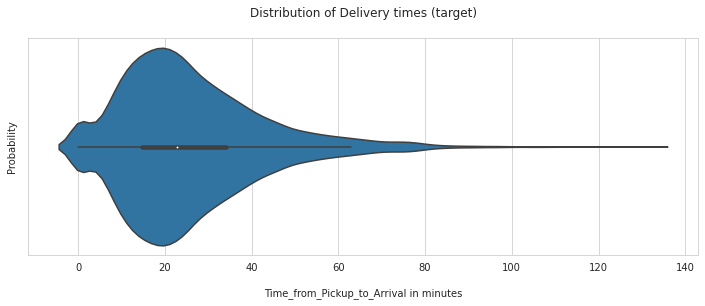

In [0]:
# Histogram
fig = plt.figure(figsize=(12,4))
sns.violinplot(eda_df[target]/60)
plt.title('Distribution of Delivery times (target)\n')
plt.xlabel('\n'+target+' in minutes')
plt.ylabel("Probability")
plt.show()

In [0]:
train_df.columns

Index(['User Id', 'Vehicle Type', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Weekday (Mo = 1)',
       'Placement - Time', 'Confirmation - Day of Month',
       'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time',
       'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival'],
      dtype='object')

#### 2. Univariate analysis (D)

2.1 Numerical

In [0]:
#Analysing the features based on one variable type
col_numerical = [col for col in eda_df.columns if eda_df[col].dtypes != 'object' and col !=target]
eda_df[col_numerical].describe()

,Platform,Place_DoM,Place_Weekday,Place_Time,Confirm_DoM,Confirm_Weekday,Confirm_Time,Arr_Pickup_DoM,Arr_Pickup_Weekday,Arr_Pickup_Time,Pickup_DoM,Pickup_Weekday,Pickup_Time,Distance_KM,Temperature,Precipitation_mm,Pickup_Lat,Pickup_Long,Destination_Lat,Destination_Long
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,1.683500e+04,552.000000,21201.000000,2.120100e+04,21201.000000,2.120100e+04
mean,2.752182,15.653696,3.240083,12.326824,15.653837,3.240225,12.447998,15.653837,3.240225,12.663223,15.653837,3.240225,12.873214,9.506533,inf,7.906250,-1.281250,inf,-1.282227,inf
std,0.625178,8.798916,1.567295,2.541007,8.798886,1.567228,2.556059,8.798886,1.567228,2.558333,8.798886,1.567228,2.551666,5.668963,3.617188e+00,17.093750,0.030548,3.918457e-02,0.034851,4.562378e-02
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.120312e+01,0.099976,-1.438477,3.665625e+01,-1.430664,3.659375e+01
25%,3.000000,8.000000,2.000000,10.000000,8.000000,2.000000,10.000000,8.000000,2.000000,11.000000,8.000000,2.000000,11.000000,5.000000,2.059375e+01,1.074219,-1.300781,3.678125e+01,-1.300781,3.678125e+01
50%,3.000000,15.000000,3.000000,12.000000,15.000000,3.000000,12.000000,15.000000,3.000000,13.000000,15.000000,3.000000,13.000000,8.000000,2.350000e+01,2.900391,-1.279297,3.681250e+01,-1.284180,3.681250e+01
75%,3.000000,23.000000,5.000000,14.000000,23.000000,5.000000,14.000000,23.000000,5.000000,15.000000,23.000000,5.000000,15.000000,13.000000,2.600000e+01,4.898438,-1.256836,3.684375e+01,-1.260742,3.684375e+01
max,4.000000,31.000000,7.000000,22.000000,31.000000,7.000000,22.000000,31.000000,7.000000,23.000000,31.000000,7.000000,23.000000,49.000000,3.209375e+01,99.125000,-1.147461,3.700000e+01,-1.030273,3.703125e+01


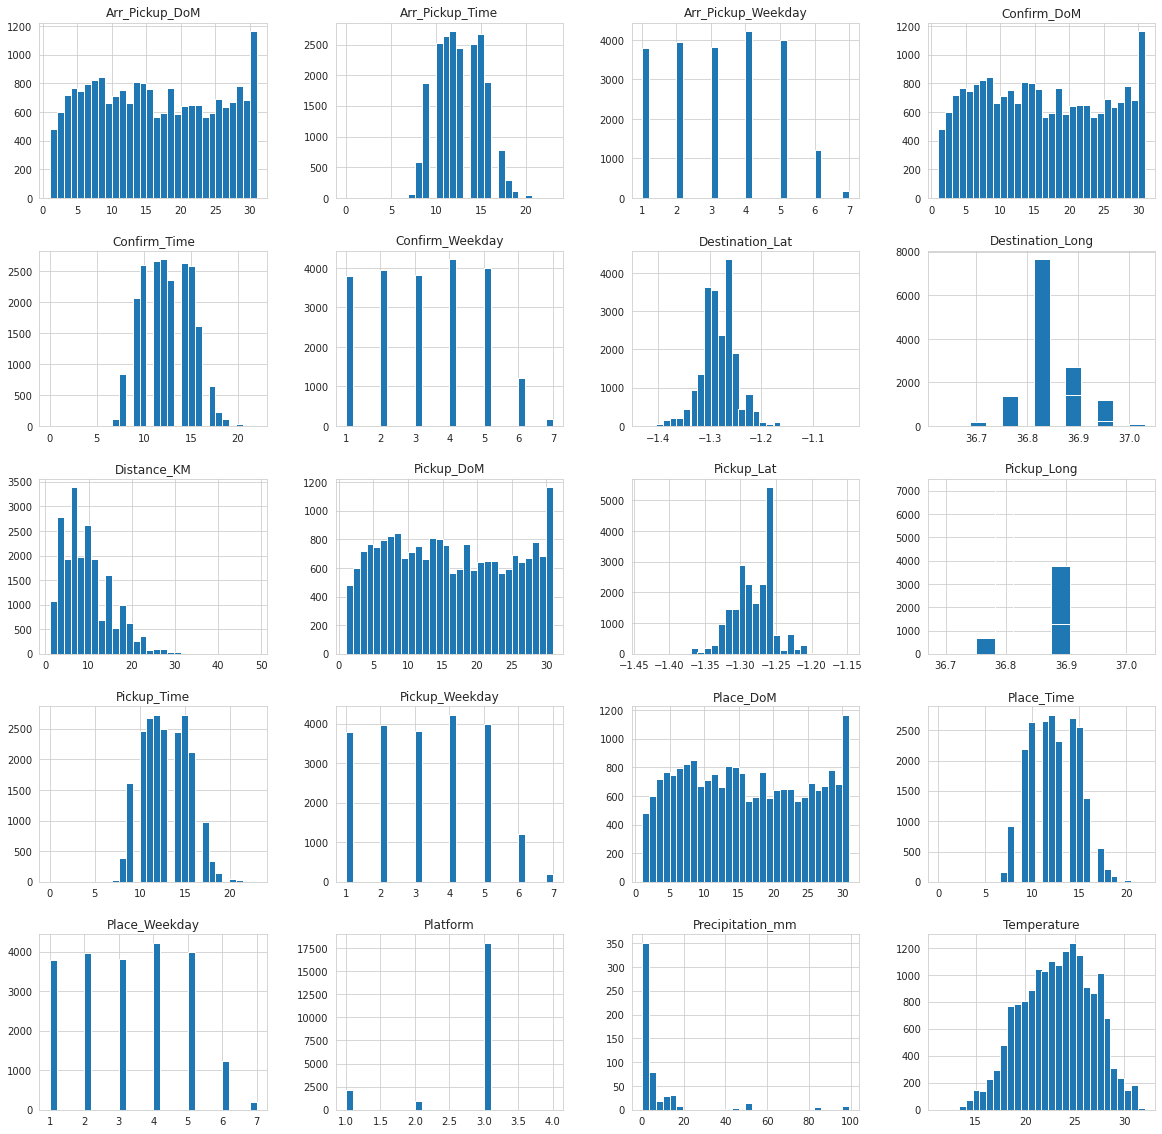

In [0]:
#Plot histogram of numerical values
def histogram_plot(df,cols,bins = 10):

  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns or object columns
  bins: string
          number of bins you want histogram to create
  Returns
  -------
  {Plot}: Returns plot of column histograms for analysis
          
  """
  df[cols].hist(bins = bins, figsize  = (20,20))
  return plt.show()
histogram_plot(eda_df,col_numerical,30)

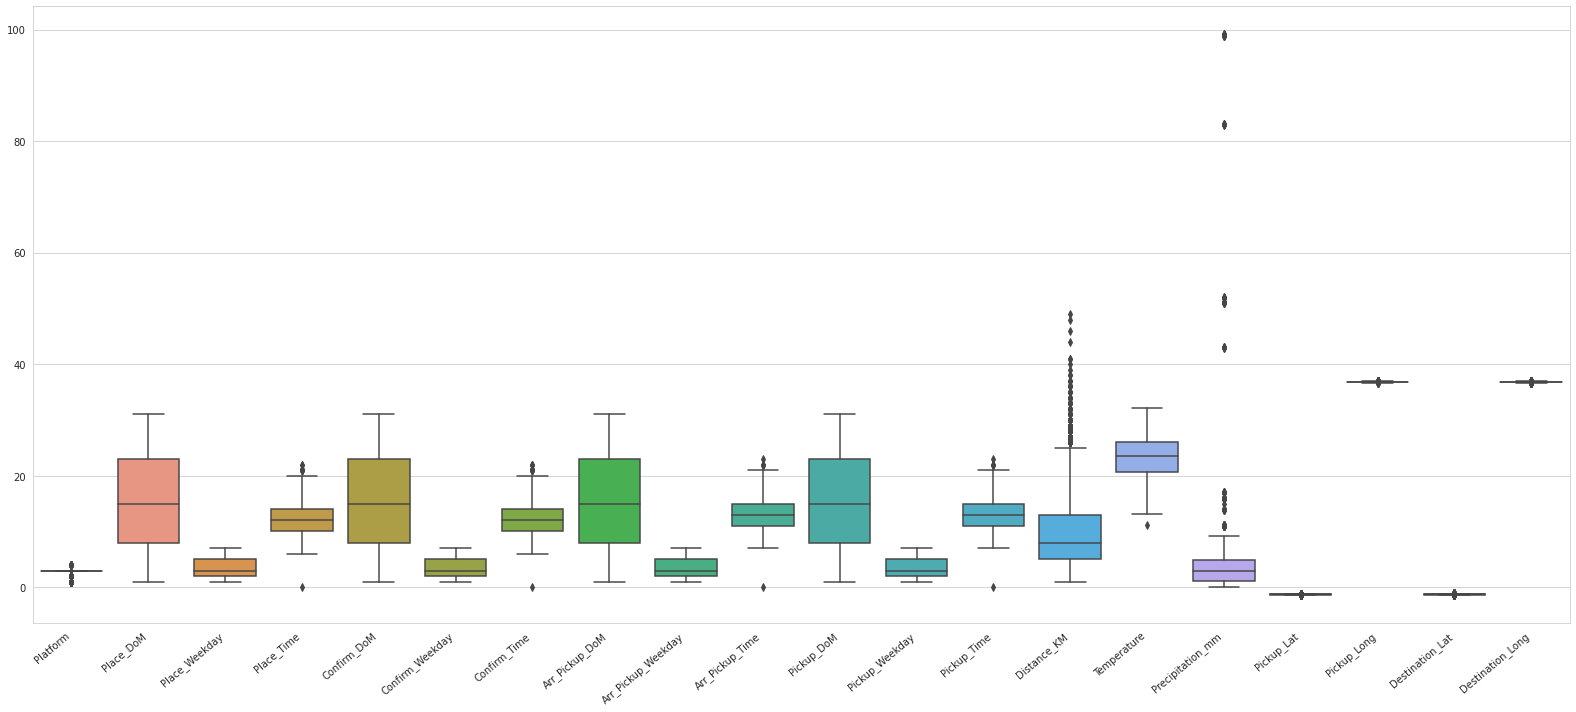

In [0]:
#Plot Boxplot of graphs
def box_plot(df,cols):
  """Function creates histogram of all numerical columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to preprocess.
  cols: list
          list of numerical columns
  Returns
  -------
  {Plot}: Returns plot of boxplot for dataframe
          
  """
  plt.figure(figsize=(22,10))
  ax = sns.boxplot(data = df[cols])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  return plt.show()
box_plot(eda_df,col_numerical)

**Analysis:** **Histogram**

From the individual numerical data plots, You can see that all the weekday varaibles follow uniform distribution except for Saturday and Sunday. Those appear to be very low compared to deliveries in the week.  

All data for days of the month follow a bimodal distribution and the peaks seem to vary between day 5-15 and day 25-30 which insinuates that the customers have capital to spend money on deliveries in these days of the month, but day 30 seems to have an exceedingly high peak compared to the rest of the days, this could be due to every client getting paid at the end of the month. 

Destination lat and long show normal distribution with most of the deliveries going to approximately (-1.28,36.85)

Pickup lat follows a normal distribution with a peak of (-1.27) and Pickup long shows a skewed left distribution which means most of the observations are happening around coordinate (36.9). Approximately between these two coordinates seem to be where most of the pickups happen.

The platform type distribution is left skewed showing that most of the deliveries by a substantial amount happen on platform 3. 

Temperature follows a normal distribution with the peak being 23.5. Distance and precipitation show a skewed right distribution with most of the kilometres ranging between 0-15km and most precipitation ranging from 0-5mm of rain.

**Analysis:** **Boxplot**

From looking at the box plot, all numerical values range differently from the plot above therefore might have to do some standardisation/normalisation for the models that depend on scaling for accuracy, the GPS range is very small since a changing the decimal coordinates slightly takes you to a new area. The distance and precipitation show outliers that may affect our results so we need to pay close attention to these two variables.



2.2 Objects

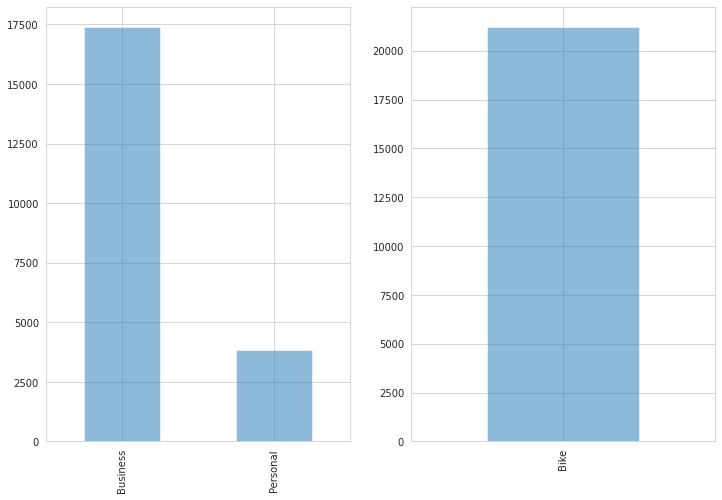

In [0]:
#Plotting two histograms to show insight of the Vehicle type and customer type
obj2_cols = [col for col in eda_df.columns if (col == 'Pers_Business')] + ['Vehicle_Type']
fig,axes = plt.subplots(1, len(obj2_cols), figsize=(12,8), squeeze=False)

for i, col in enumerate(obj2_cols):
    eda_df[obj2_cols[i]].value_counts().plot(kind='bar', x=col, ax=axes[0, i], alpha=0.5)

plt.show()

**Analysis**

From looking at the results, it shows that mainly businesses use the delivery platform and the vehicle type is only bike. Since the Vehicle type is only bike, it is safe to drop the vehicle type column as it is giving no insight to the dependent variable

In [0]:
%%capture
#Creating a hour dataframe to to get insight at the total number of deliveries volume per hour. 
#This will show in which hours most of the deliveries were made

import datetime as dt
time_cols = [col for col in eda_df.columns if col.endswith('Time')]
time_df = eda_df[time_cols]

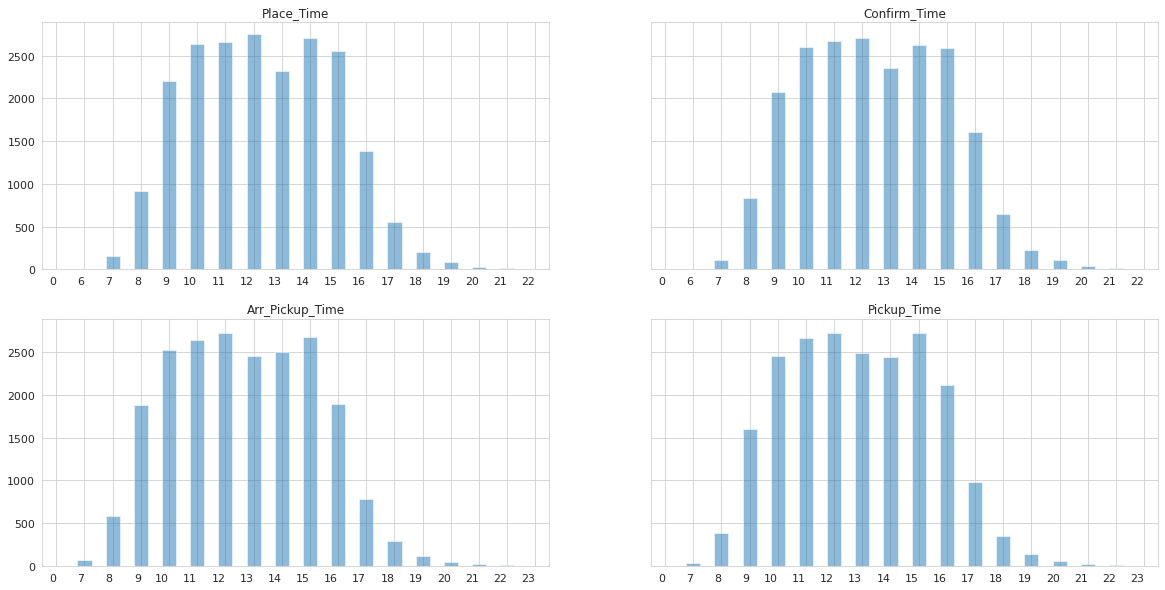

In [0]:
#Analysing the hours for further insight with bar graphs
col_names = time_df.columns

fig,axes = plt.subplots(2,2, figsize=(20,10), squeeze=False,sharey=True)
time_df[col_names[0]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[0, 0], alpha=0.5)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0, ha="right")
axes[0, 0].tick_params(labelsize=11)
axes[0, 0].set_title(col_names[0])

time_df[col_names[1]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[0, 1], alpha=0.5)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0, ha="right")
axes[0, 1].tick_params(labelsize=11)
axes[0, 1].set_title(col_names[1])

time_df[col_names[2]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[1, 0], alpha=0.5)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0, ha="right")
axes[1, 0].tick_params(labelsize=11)
axes[1, 0].set_title(col_names[2])

time_df[col_names[3]].value_counts().sort_index().plot(kind='bar',x=col_names[i], ax=axes[1, 1], alpha=0.5)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0, ha="right")
axes[1, 1].tick_params(labelsize=11)
axes[1, 1].set_title(col_names[3])

plt.show()

**Analysis**

From looking at the results it shows a normal distribution, with the peak delivery times showing a range of 9hrs - 16hrs, the times for placement, confirmation, arrival and pickup show the exact same graph, assumming that the delivery happens within the same hour from placement to destination.

In [0]:
# the user_id and rider_id get show important information of who the loyal customers are 
#and which drivers do most of the deliveries

# Select on user_id and rider_id
col_id = [col for col in eda_df.columns if col.endswith('Id')]
print(eda_df[col_id[0]].value_counts(),eda_df[col_id[1]].value_counts())

User_Id_393     645
User_Id_2330    322
User_Id_3647    312
User_Id_1500    301
User_Id_635     290
               ... 
User_Id_1391      1
User_Id_2033      1
User_Id_1114      1
User_Id_241       1
User_Id_3402      1
Name: User_Id, Length: 3186, dtype: int64 Rider_Id_726    247
Rider_Id_576    223
Rider_Id_523    199
Rider_Id_101    183
Rider_Id_205    182
               ... 
Rider_Id_236      1
Rider_Id_464      1
Rider_Id_94       1
Rider_Id_302      1
Rider_Id_251      1
Name: Rider_Id, Length: 924, dtype: int64


**Analysis**

The results above can confirm that there are loyal customers, User 393 has done double the amount of deliveries than the second highest user. It also shows rider 223 has done the most deliveries out of all the drivers.

#### 3. Bivariate analysis

In [0]:
bivariate_eda = pd.merge(eda_df, eda_riders, how='left', on='Rider_Id')

In [0]:
# #split data into smaller subset for easier analysis on scatter plots without losing relatioships in the data
# first_split = bivariate_eda.sample(frac=0.05,random_state=200)
# #Looking at the pairplot to compare variables
# grid = sns.pairplot(data = first_split)

# # Map a scatter plot to the bivariates, with alpha
# grid = grid.map_upper(plt.scatter, color = 'darkred',alpha = 0.15)
# grid = grid.map_lower(plt.scatter, color = 'darkred',alpha = 0.15)

# #reg plot
# grid = grid.map_upper(sns.regplot, color='darkred',scatter_kws={'alpha':0.15})
# grid = grid.map_lower(sns.regplot, color='darkred', scatter_kws={'alpha':0.15})

**Analysis**

This plot gives the ability to see the relationship one variable has with another, the issue with plotting pairplots that has many datapoints is overplotting. Therefore added transparency to the dots to allow for overlaps to be visible, also reduced data size by taking a random sample without losing value to the data and decrease overlapping. Further analysis will be done using a heat map, where colour indicates the number of points in each bin. 

1. **Perfect positive linearity**

We can see that all four of the day of the month categories(Placement, Confirmation, Arrival at pickup, pickup) seem to have a very strong linear relationship, this could cause multicolinearity if the model trains all these day of the month categories. The same goes for the weekdays with a few having one or two outliers, it is safe to say all weekday categories show strong linearity which should intuitively be dealt with before training the model.

2. **Positive linearity**

Distance has positve correlation with the the dependent variable y. This shows as a good indicator that there is a linear relationship.

3. **Categorical variables evident in dependent variables**

It is evident in the plot that some data shows a pattern of categorical data. The variables with this tendency is platform and weekday. The gps long coordinates show categorical patterns, but since the coordinates can take on any value with any level of specificity (or decimal places), it is confirmed to be continuous in this data form. 

4. **Futher Analysis** 

Some of the variables do not show correlation at all, the gps coordiantes lat shows a spread of data with a specific hot spot, this could be due to how close decimal degrees can be in one area but different location. The day of month and temperature seem to be quite spread out and shows no correlation. Precipitation shows no correlation but has a few deliveries with heavy rain that gives the correlation a slight positive (outliers).





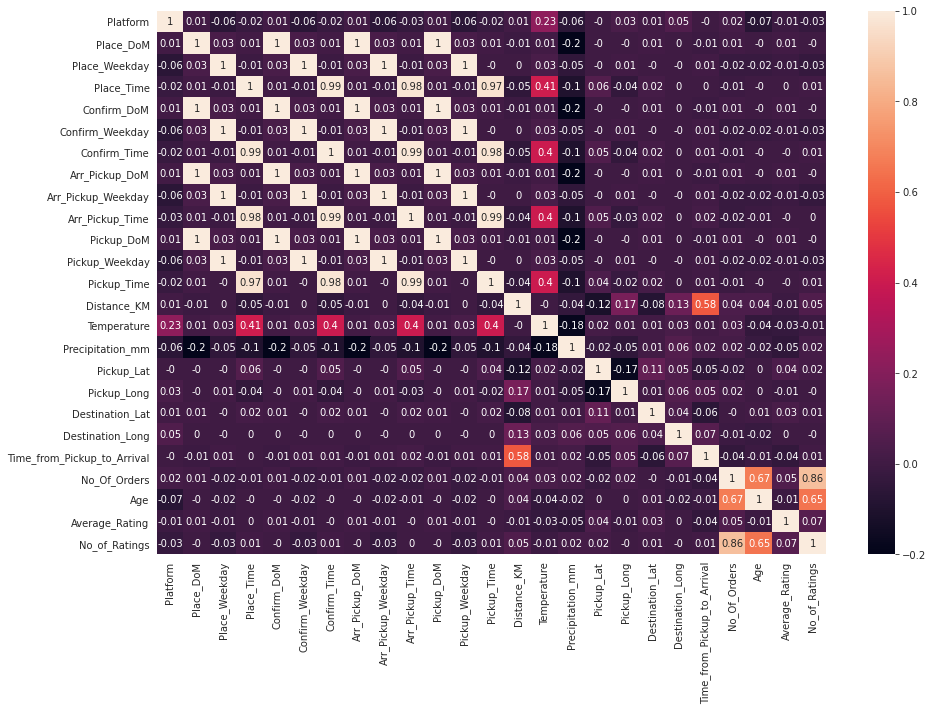

In [0]:
fig = plt.figure(figsize=(15,10))
sns.heatmap(bivariate_eda.corr().round(2), annot=True)

From the above correlation matrix some features are strongly postively and negatively correlated, suggesting that these features may lead to an increased standard error as well as a difficulty to determine the effect of any one predictor variable on the response variable. This could lead to the removal of some if not all of these features.

#### 4. Remove Collinearity


In [0]:
def collinear(df):
  """Function that drops chosen columns
  Parameters
  ----------
  df: DataFrame
          DataFrame to drop columns from
  cols: list-like
          Names of columns to be dropped from
  Returns
  -------
  col_df: DataFrame
          Modified DataFrame
  """
  col_df = pd.merge(df, eda_riders, how='left', on='Rider_Id')
  droplist = ['Place_DoM', 'Place_Weekday',
              'Place_Time', 'Confirm_DoM', 
              'Confirm_Weekday', 'Confirm_Time',
              'Arr_Pickup_DoM', 'Arr_Pickup_Weekday',
              'Arr_Pickup_Time']
  if droplist[0] in col_df.columns:
    col_df = col_df.drop(columns=droplist)
  
  return col_df


In [0]:
btrain = collinear(eda_df)
btest = collinear(eda_test)
briders = collinear(eda_riders) 


6. Missing values treatment

In [0]:
def null(df, na_thresh = 1.0 , strategy = "median"):
  """Function that drops columns with more than na_thresh null from
  
  """
  no_null=df.copy()
  # Dropping NaN's
  for col in no_null.columns:
    missing = no_null[col].isnull().sum()/len(no_null)
    if missing > na_thresh:
      no_null.drop(columns=col, inplace=True)
    
  # Filling NaN's
  for col in no_null.columns:
    if no_null[col].isnull().sum() > 0:
      if no_null[col].dtypes == 'object':
        no_null[col].fillna(no_null[col].mode(), inplace=True) 
      elif strategy == 'mean':
        no_null[col].fillna(round(no_null[col].mean()), inplace=True)
      elif strategy == 'median':
        no_null[col].fillna(round(no_null[col].median()), inplace=True)
      elif strategy == 'rolling':
        no_null[col].fillna(no_null[col].rolling(7).mean(), inplace=True)
      else:
        raise ValueError
  return no_null

In [0]:
ctrain = null(btrain)
ctest = null(btest)
criders = null(briders)

In [0]:
ctrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   User_Id                      21201 non-null  object 
 1   Vehicle_Type                 21201 non-null  object 
 2   Platform                     21201 non-null  int16  
 3   Pers_Business                21201 non-null  object 
 4   Pickup_DoM                   21201 non-null  int16  
 5   Pickup_Weekday               21201 non-null  int16  
 6   Pickup_Time                  21201 non-null  int64  
 7   Distance_KM                  21201 non-null  int16  
 8   Temperature                  21201 non-null  float16
 9   Precipitation_mm             21201 non-null  float16
 10  Pickup_Lat                   21201 non-null  float16
 11  Pickup_Long                  21201 non-null  float16
 12  Destination_Lat              21201 non-null  float16
 13  Destination_Long

b. Feature engineering and selection (B)


1. Variable transformation

In [0]:
time_cols

['Place_Time', 'Confirm_Time', 'Arr_Pickup_Time', 'Pickup_Time']

In [0]:
def variable_transformer(df):
  """Function to apply variable ALL transformations to dataset
  Parameters
  ----------
  df: DataFrame
          Input df to be transformed
  Returns
  -------
  trans_df: DataFrame
          Output df
  """
  index = df.index
  trans_df = df.copy()

  # # Time to number
  # for time in time_cols:
  #   if time in trans_df.columns:
  #     trans_df[time] = pd.to_datetime(trans_df[time])



  # # Feature scaling
  # predictor_cols = ['Distance_KM'	,'Temperature	','Precipitation_mm', 'No_Of_Orders', 'Age', 'Average_Rating',	'No_of_Ratings']
  # sc = StandardScaler()
  # sc.fit_transform(trans_df[predictor_cols])
  
  # Drop unnecessary features
  droplist = ['User_Id', 'Vehicle_Type', 'Rider_Id'] #, 'Pickup_Lat',	'Pickup_Long',	'Destination_Lat',	'Destination_Long', 'Temperature','Precipitation_mm', 'Pay_Day', 'Pickup_DoM']
  for col in droplist:
    if col in trans_df.columns:
      trans_df.drop(columns=col, inplace=True)

  # Reorder columns
  reindex_cols = [col for col in trans_df.columns if col != target] + [target]
  trans_df = trans_df.reindex(columns = reindex_cols)
  trans_df.index = (index)
  original_features = [col for col in trans_df.columns if col != target]
  return trans_df, original_features

In [0]:
# Building final dataframes with complete features
dtrain, o_features = variable_transformer(ctrain)
dtest, test = variable_transformer(ctest)

2. Variable creation

In [0]:
def variable_creator(df):
  """Doctstring here
  """
  create_df = df.copy()
  
  # covert GPS corrdinates to distance
  def dist(df,lat1,long1,lat2,long2):
      list1=[]
      geo_df = df.copy()
      for i in range (0,len(geo_df)):
          coords_1 = (geo_df[lat1][i], geo_df[long1][i])
          coords_2 = (geo_df[lat2][i], geo_df[long2][i])

          distance=geopy.distance.vincenty(coords_1, coords_2).m
          #print(distance)
          list1.append(distance)
      geo_df['Geo_Distance'] = list1
      return geo_df
  create_df = dist(create_df,'Pickup_Lat', 'Pickup_Long', 'Destination_Lat',
        'Destination_Long')
 
  # # Extract hours from columns
  # create_df['Pickup_Hour'] = pd.to_datetime(create_df['Pickup_Time'].astype(str)).dt.hour
  
 
  
  # Determine which platform is busiest
  def is_busy(platform):
    if platform == 3:
      return True
    else:
      return False
  create_df['Platform_load'] = create_df['Platform'].apply(is_busy)

  # Which drivers are the most experienced
  def experience(age):
    if age < 1000:
      return 1
    elif age < 2000:
      return 2
    elif age < 3000:
      return 3
    return 4
  create_df['Driver_exp'] = create_df['Age'].apply(experience)

  # Business day
  def weekday(day):
    if day in [1,2,3,4,5]:
      return 1
    return 0
  create_df['Business_day'] = create_df['Pickup_Weekday'].apply(weekday)

  # Is it hot?
  def comfort(temp):
    
    if temp < 18:
      return 0
    elif temp < 28.75:
      return 1
    return 2
  create_df['Comfort'] = create_df['Temperature'].apply(comfort)

  # Is pay day?
  def pay_day(DoM):
    if DoM in [30,31]:
      return True
    return False
  create_df['Pay_Day'] = create_df['Pickup_DoM'].apply(pay_day)
    
  # Get dummies
  dummy_cols = ['Pers_Business','Pickup_Weekday', 'Pickup_DoM','Platform','Pickup_Time']
  create_df = pd.get_dummies(create_df,columns = dummy_cols, drop_first=True,)
  
  # Reorder columns
  reindex_cols = [col for col in create_df.columns if col != target] + [target]
  create_df = create_df.reindex(columns = reindex_cols)
  

  
  create_features = [col for col in create_df.columns if col not in df.columns]

  return create_df, create_features

In [0]:
# Building final dataframes with complete features
etrain, c_features  = variable_creator(dtrain)
etest, test_feats = variable_creator(dtest)

## 6. Model building

In [0]:
# Creating working df
final = etrain.copy()
final_features = [# 'Feature',  # Individual P-Score
                  # 'Platform',
                  # 'Pers_Business',
                  # 'Pickup_DoM',
                  # 'Pickup_Weekday',
                  # 'Pickup_Time',
                  'Distance_KM', # P - 0.00
                  # 'Temperature', # P - 0.305
                  # 'Precipitation_mm', # P - 0.216
                  # 'Pickup_Lat', # location does not consider obstacles
                  # 'Pickup_Long',  # location does not consider obstacles
                  # 'Destination_Lat',  # location does not consider obstacles
                  # 'Destination_Long', # location does not consider obstacles 
                  # 'No_Of_Orders', # condition number is large, 5.09e+03.
                  # 'Age', # condition number is large, 2.88e+03.
                  'Average_Rating', # P - 0.000
                  # 'No_of_Ratings', # condition number is large, 1.11e+03.
                  # 'Geo_Distance',  # condition number is large, 1.6e+04.
                  # 'Platform_load', # P - 0.229
                  'Driver_exp', # P - 0.000
                  # 'Business_day', # P - 0.000 # multicollinearity
                  # 'Comfort', # P - 0.104
                  # 'Pay_Day', # P - 0.306
                  'Pers_Business_Personal', # P - 0.002
                  'Pickup_Weekday_2', # P - 0.000
                  # 'Pickup_Weekday_3', # P - 0.369
                  # 'Pickup_Weekday_4', # P - 0.123
                  'Pickup_Weekday_5', # P - 0.000 
                  'Pickup_Weekday_6', # P - 0.000
                  # 'Pickup_Weekday_7', # P - 0.292
                  # 'Pickup_DoM_2', # P - 0.939
                  # 'Pickup_DoM_3', # P - 0.947
                  # 'Pickup_DoM_4', # P - 0.355
                  # 'Pickup_DoM_5', # P - 0.577
                  # 'Pickup_DoM_6', # P - 0.737
                  # 'Pickup_DoM_7', # P - 0.304
                  'Pickup_DoM_8', # P - 0.023
                  'Pickup_DoM_9', # P - 0.021
                  # 'Pickup_DoM_10', # P - 0.725
                  'Pickup_DoM_11', # P - 0.140
                  # 'Pickup_DoM_12', # P - 0.332
                  # 'Pickup_DoM_13', # P - 0.550
                  # 'Pickup_DoM_14', # P - 0.288
                  # 'Pickup_DoM_15', # P - 0.735
                  # 'Pickup_DoM_16', # P - 0.195
                  'Pickup_DoM_17', # P - 0.098
                  # 'Pickup_DoM_18', # P - 0.229
                  # 'Pickup_DoM_19', # P - 0.425
                  # 'Pickup_DoM_20', # P - 0.845
                  # 'Pickup_DoM_21', # P - 0.553
                  'Pickup_DoM_22', # P - 0.098
                  # 'Pickup_DoM_23', # P - 0.500
                  # 'Pickup_DoM_24', # P - 0.627
                  # 'Pickup_DoM_25', # P - 0.352
                  # 'Pickup_DoM_26', # P - 0.245
                  'Pickup_DoM_27', # P - 0.001
                  # 'Pickup_DoM_28', # P - 0.746
                  'Pickup_DoM_29', # P - 0.096
                  'Pickup_DoM_30', # P - 0.079 
                  # 'Pickup_DoM_31', # P - 0.565
                  # 'Platform_2', # P - 0.342
                  # 'Platform_3', # P - 0.229
                  # 'Platform_4', # P - 0.155
                  # 'Pickup_Time_7',  # P - 0.947
                  'Pickup_Time_8',  # P - 0.043
                  'Pickup_Time_9',  # P - 0.000
                  'Pickup_Time_10', # P - 0.000
                  # 'Pickup_Time_11', # P - 0.380
                  'Pickup_Time_12', # P - 0.086
                  # 'Pickup_Time_13', # P - 0.879
                  # 'Pickup_Time_14', # P - 0.625
                  'Pickup_Time_15', # P - 0.000
                  'Pickup_Time_16', # P - 0.086
                  # 'Pickup_Time_17', # P -0.325
                  # 'Pickup_Time_18', # P - 0.585
                  # 'Pickup_Time_19', # P - 0.741
                  # 'Pickup_Time_20', # P - 0.461
                  # 'Pickup_Time_21', # P - 0.300
                  # 'Pickup_Time_22', # P - 0.158
                  # 'Pickup_Time_23' # P - 0.514
                  ]

In [0]:
final[final_features+[target]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21201 entries, 0 to 21200
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Distance_KM                  21201 non-null  int16  
 1   Average_Rating               21201 non-null  float16
 2   Driver_exp                   21201 non-null  int64  
 3   Pers_Business_Personal       21201 non-null  uint8  
 4   Pickup_Weekday_2             21201 non-null  uint8  
 5   Pickup_Weekday_5             21201 non-null  uint8  
 6   Pickup_Weekday_6             21201 non-null  uint8  
 7   Pickup_DoM_8                 21201 non-null  uint8  
 8   Pickup_DoM_9                 21201 non-null  uint8  
 9   Pickup_DoM_11                21201 non-null  uint8  
 10  Pickup_DoM_17                21201 non-null  uint8  
 11  Pickup_DoM_22                21201 non-null  uint8  
 12  Pickup_DoM_27                21201 non-null  uint8  
 13  Pickup_DoM_29   

In [0]:
# Setting the seed
rs = 42
# Features (X), Target(y)
X = final[final_features].values
y = final[target].values

# Train/Test split (size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16960, 21) (4241, 21) (16960,) (4241,)


Analysis of Features

In [0]:
OLS_df = final[final_features+[target]].copy()
X_names = [col for col in OLS_df.columns if col != target and col != 'Order_No']
# Build the OLS formula string " y ~ X "
formula_str = target+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 Time_from_Pickup_to_Arrival ~ Distance_KM + Average_Rating + Driver_exp + Pers_Business_Personal + Pickup_Weekday_2 + Pickup_Weekday_5 + Pickup_Weekday_6 + Pickup_DoM_8 + Pickup_DoM_9 + Pickup_DoM_11 + Pickup_DoM_17 + Pickup_DoM_22 + Pickup_DoM_27 + Pickup_DoM_29 + Pickup_DoM_30 + Pickup_Time_8 + Pickup_Time_9 + Pickup_Time_10 + Pickup_Time_12 + Pickup_Time_15 + Pickup_Time_16


In [0]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=OLS_df)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                                 OLS Regression Results                                
Dep. Variable:     Time_from_Pickup_to_Arrival   R-squared:                       0.345
Model:                                     OLS   Adj. R-squared:                  0.344
Method:                          Least Squares   F-statistic:                     531.2
Date:                         Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                                 16:04:11   Log-Likelihood:            -1.7178e+05
No. Observations:                        21201   AIC:                         3.436e+05
Df Residuals:                            21179   BIC:                         3.438e+05
Df Model:                                   21                                         
Covariance Type:                     nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

Validation

In [0]:
# KFold Cross Validation
kf = KFold(n_splits=10,shuffle=False)
kf.split(X)
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

# List of regressors to test
regressors = []
# regressors.append(LinearRegression())
# regressors.append(Lasso(random_state=rs))
# regressors.append(DecisionTreeRegressor(random_state=rs))
# regressors.append(RandomForestRegressor(random_state=rs))
# regressors.append(ExtraTreesRegressor(random_state=rs))
# regressors.append(xgb.XGBRegressor(random_state=rs,
                                  #  objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))
# regressors.append(GradientBoostingRegressor(random_state=rs))

def cross_val(regressors, kfold):
  """Function that returns a DataFrame of model scores and errors gain and loss
  """
  regressors
  cv_results = []
  cv_means = []
  cv_stds = []
  cv_loss = []

  # Train and test regressors (Long time)
  for regressor in regressors:
    cv_results.append(np.sqrt(abs(cross_val_score(regressor,
                                                  X_train,
                                                  y=y_train,
                                                  scoring='neg_mean_squared_error',
                                                  cv=kfold))))

  for cv_result in cv_results:
    cv_means.append(round(cv_result.mean(),2))
    cv_stds.append(round(cv_result.std(),2))
    cv_loss.append(round(min(cv_result),2))

    
  cv_res = pd.DataFrame({ 
    "Algorithm":["LGB"],#, "XTR","MLR", "LASSO","RFR", "XGBR","GBR""DTR", 
    "Mean RMSE": cv_means,
    "Std Error": cv_stds,
    "Min": cv_loss,
                       })
  cv_res = cv_res.sort_values("Mean RMSE", ascending=True)
  return cv_res

In [0]:
cross_val(regressors, kfold)

,Algorithm,Mean RMSE,Std Error,Min
0,LGB,788.88,23.66,738.87


Hyperparameter Optimization

In [0]:
%%time

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)
        
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])
     
    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                           'subsample': (0.01, 1.0)}, random_state=200)

    
    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.
    
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])
    
    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16 µs


In [0]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=10, random_seed=6,n_estimators=10000)

|   iter    |  target   | baggin... | featur... | learni... |  max_bin  | max_depth | min_da... | min_su... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  1        |  1.0      |  0.9895   |  0.2812   |  0.5985   |  49.98    |  24.1     |  20.17    |  35.74    |  74.94    |  0.4615   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  2        |  1.0      |  0.9964   |  0.7939   |  0.9862   |  84.63    |  12.59    |  70.77    |  12.12    |  67.99    |  0.258    |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  3        |  1.0      |  0.8192   |  0.8548   |  0.8278   |  56.28    |  26.84    |  54.7     |  45.01    |  62.09    |  0.4252   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  4        |  1.0      |  0.9281   |  0.5869   |  0.1144   |  87.62    |  23.97    |  60.78    |  32.93    |  25.48    |  0.8056   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  5        |  1.0      |  0.9946   |  0.3264   |  0.6526   |  38.59    |  9.692    |  45.14    |  66.6     |  52.98    |  0.8559   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  6        |  1.0      |  0.8547   |  0.4003   |  0.6962   |  24.2     |  15.32    |  78.9     |  97.79    |  25.94    |  0.5686   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  7        |  1.0      |  0.8726   |  0.3116   |  0.6133   |  22.76    |  8.84     |  21.06    |  4.765    |  26.02    |  0.2456   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  8        |  1.0      |  0.8531   |  0.5894   |  0.3971   |  86.88    |  13.08    |  29.2     |  99.73    |  25.58    |  0.7243   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  9        |  1.0      |  0.8027   |  0.3417   |  0.7634   |  23.11    |  23.64    |  21.96    |  96.34    |  79.51    |  0.4476   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  10       |  1.0      |  0.8445   |  0.3894   |  0.8828   |  87.86    |  5.342    |  79.13    |  95.67    |  75.99    |  0.7224   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  11       |  1.0      |  0.8722   |  0.539    |  0.1459   |  75.5     |  29.72    |  68.65    |  31.57    |  33.03    |  0.07075  |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  12       |  1.0      |  0.9735   |  0.8011   |  0.01059  |  22.04    |  17.69    |  74.07    |  0.9261   |  77.89    |  0.4858   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  13       |  1.0      |  0.8921   |  0.3534   |  0.1975   |  21.43    |  27.88    |  77.54    |  98.74    |  29.03    |  0.1942   |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  14       |  1.0      |  0.9479   |  0.8709   |  0.1779   |  88.82    |  5.384    |  20.38    |  0.07029  |  74.12    |  0.238    |


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


|  15       |  1.0      |  0.8512   |  0.1726   |  0.5423   |  22.71    |  6.478    |  78.5     |  2.444    |  37.25    |  0.4017   |


In [0]:
opt_params

(1.0,
 {'bagging_fraction': 0.9895264513703341,
  'feature_fraction': 0.2812379369053784,
  'learning_rate': 0.5984759429472213,
  'max_bin': 49.981607945078636,
  'max_depth': 24.10351716384675,
  'min_data_in_leaf': 20.171635500856567,
  'min_sum_hessian_in_leaf': 35.74236812873617,
  'num_leaves': 74.94291359717887,
  'subsample': 0.4615201756036703})

In [0]:
lgbr = lgb.LGBMRegressor(bagging_fraction = 0.1,
                         boosting_type='gbdt',
  feature_fraction = 0.2812379369053784,
  learning_rate = 0.32,
  max_bin = 49,
  max_depth = 4,
  min_data_in_leaf = 20,
  min_sum_hessian_in_leaf = 35.74236812873617,
  num_leaves = 75,
  subsample = 0.4615201756036703)

In [0]:
lgbr.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.2812379369053784,
              importance_type='split', learning_rate=0.32, max_bin=49,
              max_depth=4, min_child_samples=20, min_child_weight=0.001,
              min_data_in_leaf=20, min_split_gain=0.0,
              min_sum_hessian_in_leaf=35.74236812873617, n_estimators=100,
              n_jobs=-1, num_leaves=75, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.4615201756036703, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
y_pred = lgbr.predict(X_test)
y_pred_train = lgbr.predict(X_train)
# check RMSE
mse = mean_squared_error(y_test,y_pred)
msetrain = mean_squared_error(y_train,y_pred_train)
RMSE = np.sqrt(mse)
RMSEt = np.sqrt(msetrain)
print("Train RMSE: \t",RMSEt,"\nTest RMSE: \t", RMSE,"\nDifference\t:", RMSEt-RMSE)

Train RMSE: 	 775.349406507334 
Test RMSE: 	 766.6688004092889 
Difference	: 8.680606098045132


Bagging

In [0]:
# Instantiate BaggingRegressor model with a decision tree as the base model
bag_reg = BaggingRegressor(base_estimator = lgbr)
bag_reg.fit(X_train, y_train)

BaggingRegressor(base_estimator=LGBMRegressor(bagging_fraction=0.1,
                                              boosting_type='gbdt',
                                              class_weight=None,
                                              colsample_bytree=1.0,
                                              feature_fraction=0.2812379369053784,
                                              importance_type='split',
                                              learning_rate=0.32, max_bin=49,
                                              max_depth=4, min_child_samples=20,
                                              min_child_weight=0.001,
                                              min_data_in_leaf=20,
                                              min_split_gain=0.0,
                                              min_sum_hessian_in_leaf=35.74236812873617,
                                              n_estimators=100, n_jobs=-1,
                                              num_l

In [0]:
y_pred = bag_reg.predict(X_test)
y_pred_train = bag_reg.predict(X_train)
# check RMSE
mse = mean_squared_error(y_test,y_pred)
msetrain = mean_squared_error(y_train,y_pred_train)
RMSE = np.sqrt(mse)
RMSEt = np.sqrt(msetrain)
print("Train RMSE: \t",RMSEt,"\nTest RMSE: \t", RMSE,"\nDifference\t:", RMSEt-RMSE)

Train RMSE: 	 775.2103213275316 
Test RMSE: 	 764.9749286964704 
Difference	: 10.235392631061131


In [0]:
model_save_path = "Team_13_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)

## 6. Results interpretation

**6.1 EXPLORATION DATA ANALYSIS**
Exploration Data Analysis (EDA) is  a process where a number of techniques are used to better understand the dataset being used.The reason behind EDA is to have a good understanding of the dataset and also to use necessary steps to utilize the data inorder to extract information from the data.The steps that were followed in this section includes ,Extracting important variables and leaving behind  variables that was not needed
Identifying outliers, missing values, or human error
Understanding the relationship(s), or lack of, between variables
Ultimately, maximizing your insights of a dataset and minimizing potential error later in the process.

Inorder to understand the target variable, a histogram was used to visiualize the data and also understand the relationship it has with the independent variable(s).From the Histogram that is illustrated, shows that the mean is greater than the median , which means the histogram is skewed to the right.

Furthermore, data was also divided into the Univariate and Bivariate analysis.Where Univariate analysis is the simplest form of data analysis where the data being analyzed contains only one variable. Since it's a single variable it doesn’t deal with causes or relationships.  The main purpose of univariate analysis is to describe the data and find patterns that exist within it. In this case variables such as Platforms, confirmation,Placements_Weekdays etc were analysed using the histograms, inorder to extract as much information as possible and also to make an informed decision with regards to which variables keep and which ones will not be necessary to have at a later stage .

The remain Independent variables were then analysed using the Bivariate analysis.Bivariate analysis  used to find out if there is a relationship between the independent variables and the dependent  variable. In this case the scatterplots and heatmap were used to illustrated  the relationship between the  variables .The heatmap was used to show correlation between the variables, the variables that had the least correlation with the target variable (Time from pickup to arrival) were then dropped since they wont have any significant use at a later stage of the project.

Scatterplot were used to determine any outlier that could possible affect the predicted RMSE or the performance of the model at a later stage .After that all these processes, an informed decision with regards to dropping unnecesarry variables. 


Furthermore, in this stage the missing value were also treated, depending on how valuable the data is . Whilst treating the missing data , careful consideration were taken due to the fact how it is treated could affect the performance of the model. In this case, the precipitation had the most missing values , which are approximately 97%  and Temperature have 20% missing value. The median in this case was used to calculate the missing values.

6.3 MODEL BULDING 

At this final stage of the data interpretation, after the EDA and Feature engineering are done ,the  data is now ready to be utilized in building the model.Different models were placed into test before the best perfoming model was chosen.The models that were tested are as follows, Linear Regression,Lasso Regressor(Random_state),Randomn Forest Regressor, Extra Tree Regressor and XGBR Regressor.

From the abovementioned Regression model , the model that performed best was then selected to be the one that carries on to do the prediction. All this regression model were tested using the kfold validation. Quick recap, Cross validation is a statistical method used to estimate the skill of machine learning models.

It is commonly used in applied machine learning to compare and select a model for a given predictive modeling problem.In the case of this project, the number of splits that were used in the kfold methods are 10, which means the data was splited into approximately 10 equal sizes. After the dataset has been divided, For each unique group: the other group will be  held out or be used as test data set, the remaining groups were used as the  training data set, lastly a model was fitted  on the training set and evaluate it on the test set.This processes was done so the model could be settled.

From the previous Section (Model Bulding) specifically under the k-fold cross validation , the observation could clearly indicated the best perfoming model, in this instance the the best one was the LGBM (LightGBM)with the  RMSE 788.88 and the stanadrd deviation error of 23.66 .

The lightGBM is defined as the gradient boosting framework which uses tree based learning algorathims. The reason behind using this algorithm besides ,it  having the best perfoming model is because of its faster training speed and higher efficiency.

After the best perfoming model has been determined, the hyperparameters were used  to observe how it affects the model's accuracy.  In this case,observing were mainly focused on how changing the number of estimators and the criterion can affect our Random Forest accuracy. From the results that were obtained, it shows that the Train RMSE is 775.35(2 decimals),and the recently the Test RMSE is now 766.67 (2 decimals), which means the difference between the RMSE is 8 , and therefore there is not much of a difference and this also emphasizes that the hyperparameters that has been choosen align with the results that have were gotten from the initial stage of training the model.In this case the  Bayesian optimization hyperparameters was choosen,because they use past evaluation results to choose the next values to evaluate and that asisted with the predicted  RMSE accuracy. In conclusion  the concept is limit expensive evaluations of the objective function by choosing the next input values based on those that have done well in the past.


After the second RMSE prediction, the bagging method was the introduced. The reason behind choosing this method (Bagging) is because the aim was to create stability and improve the accuracy of the RMSE , that was obtained from the previous prediction. Furthermore, this methods also reduces the  varience and therefore overfitting is avoided at all costs.The prediction that have been calculated previsouly is still within a small range.After the Bagging method was used,  the RMSE has only changed from 775.21  to 764.74 .

From  the bagging , Baysein optimazation hyperparameters and the cross validation methods, the model at this instance is perfoming at it outmost best and the prediction that has been made are likely to bring the best insights for Sendy logists .


## 7. Conclusion

From all the steps and processes that were followed in this project until the model was built , with confidence it is easy to say the this model has made the most accurate results, that will help Sendy logistics with insights and that could be beneficial to the business . Furthermore, Sendy logistics can now see what needs more improvement .